In [ ]:
# TODO: This notebook is broken. Fix it.

In [1]:
from importlib import reload
from os.path import join
from collections import defaultdict
import sys
import os
import numpy as np
from matplotlib import pyplot

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as tf
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [3]:
from datasets.dshdf5pose import Hdf5PoseDataset
import datatransformation
import neuralnets.models
import neuralnets.modelcomponents
import vis
import utils
import train

In [4]:
%matplotlib notebook

In [5]:
net = neuralnets.models.LocalizerNet()
state_dict = torch.load( join('..','model_files','best_LocalizerNet.ckpt'))
neuralnets.modelcomponents.clear_denormals_inplace(state_dict)
net.load_state_dict(state_dict)
net.eval()
net.cuda()

Denormals or zeros:
convnet.6.layers.4.running_mean         :          1 (1.25%)
convnet.6.layers.4.running_var          :          1 (1.25%)
convnet.9.layers.4.running_mean         :          2 (3.125%)
convnet.9.layers.4.running_var          :          2 (3.125%)
convnet.10.layers.0.weight              :         32 (1.5625%)
convnet.10.layers.1.running_mean        :          1 (1.5625%)
convnet.10.layers.1.running_var         :          1 (1.5625%)
convnet.10.layers.3.weight              :          9 (1.5625%)
convnet.10.layers.4.weight              :          1 (1.5625%)
convnet.10.layers.4.bias                :          1 (1.5625%)
convnet.10.layers.4.running_mean        :          3 (4.6875%)
convnet.10.layers.4.running_var         :          3 (4.6875%)
convnet.10.layers.6.weight              :         32 (1.5625%)
convnet.11.layers.0.weight              :         31 (1.513671875%)
convnet.11.layers.1.running_mean        :          1 (1.5625%)
convnet.11.layers.1.running_var     

LocalizerNet(
  (initial_stage): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (convnet): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=8, bias=False)
      (1): BatchNorm2d(8, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(8, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (4): BatchNorm2d(8, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    )
    (2): _InvertedResidual(
      (layers): Sequential(
        (0): Conv2d(8, 16, kernel_size=(1, 1), str

In [6]:
# Adjust as needed
path = join(os.environ['DATADIR'],'widerfacessingle.h5')

testset = Hdf5PoseDataset(
        path,
        shuffle = False,
        subset = slice(500),
        transform=transforms.Compose([
            datatransformation.RescaleMaintainAspect(net.input_resolution),
            datatransformation.Normalize(monochrome=True),
            datatransformation.ToTensor(),
]))

test_loader = DataLoader(testset, 
                          batch_size=32,
                          shuffle=False, 
                          num_workers=6)

In [7]:
def iterate_predictions(loader, net):
    for batch in loader:
        with torch.no_grad():
            preds = net.inference(batch['image'].cuda())
            preds = { k:v.cpu() for k,v in preds.items() }
        for sample, pred in zip(utils.undo_collate(batch), utils.undo_collate(preds)):
                yield vis.unnormalize_sample_to_numpy(sample, pred)

<IPython.core.display.Javascript object>


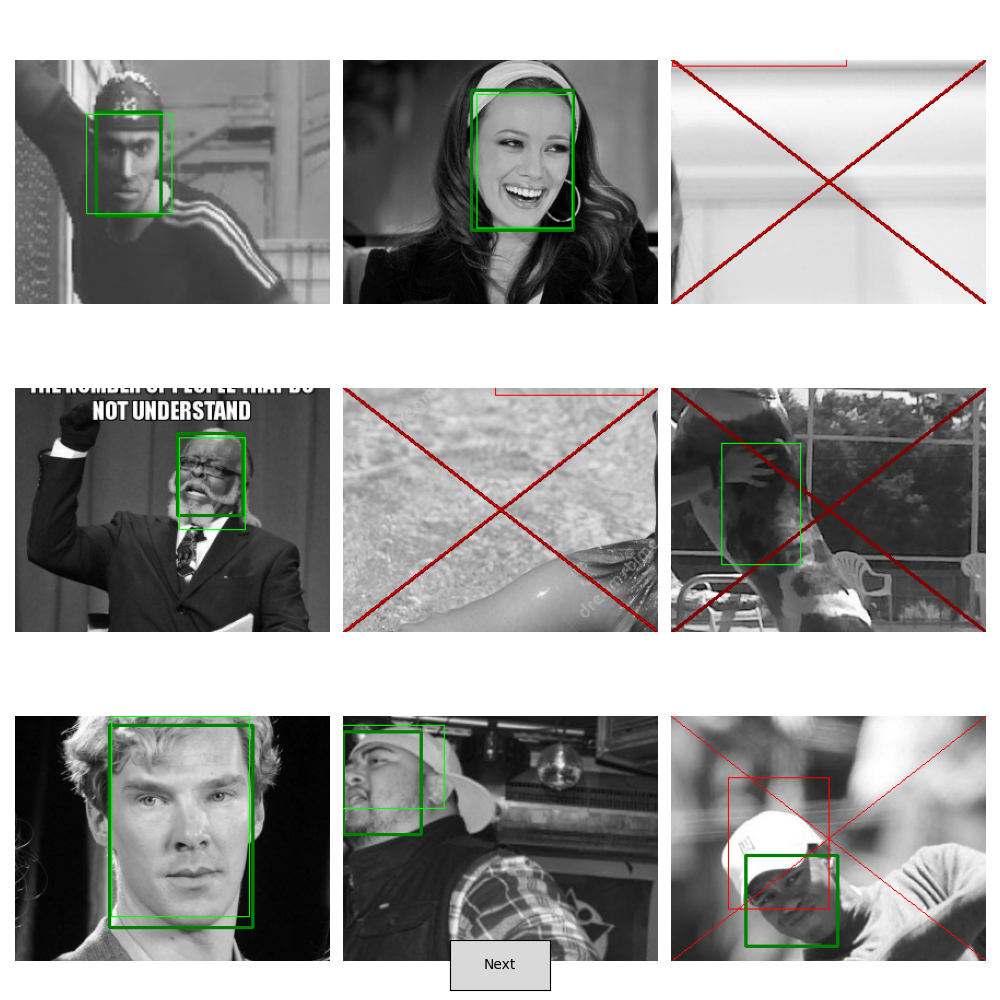

(<Figure size 1000x1000 with 10 Axes>,
 <matplotlib.widgets.Button at 0x7fc9f025dfd0>)

In [8]:
vis.matplotlib_plot_iterable(iterate_predictions(test_loader, net), vis.draw_prediction)

In [9]:
def analyze(net, loader, detection_threshold):
    err, matches = train.metrics_over_full_dataset(
        net, 
        [ train.LocalizerBoxMeanSquareErrors(detection_threshold), train.LocalizerIsFaceMatches(detection_threshold) ], 
        loader)
    err = err[np.isfinite(err)]
    matches = matches[np.isfinite(matches)]
    accuracy = np.average(matches.astype(np.float))
    corner_point_rmse = np.sqrt(np.average(err.ravel()))
    print (f"Threshold {detection_threshold} => Acc {accuracy*100:.0f}%, RMSE {corner_point_rmse:0.2f}")

In [10]:
analyze(net, test_loader, 0.25)
analyze(net, test_loader, 0.5)
analyze(net, test_loader, 0.75)

Threshold 0.25 => Acc 85%, RMSE 0.23
Threshold 0.5 => Acc 92%, RMSE 0.22
Threshold 0.75 => Acc 91%, RMSE 0.17
